In [5]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
%matplotlib inline
plt.viridis()
from matplotlib import animation, rc
from IPython.display import HTML

In [19]:
data = np.load("D:/Work/Neurogenesis-PhD/synaptogenesis/topographic_map_results_204155_21072017.npz")
print "This took", data['total_time'], "to simulate"

 This took 3:53:15.955000 to simulate


In [7]:
simtime = int(data['simtime'])
post_spikes = data['post_spikes']

In [8]:
count_spikes = np.zeros(256)
for id, time in post_spikes:
    count_spikes[int(id)] += 1

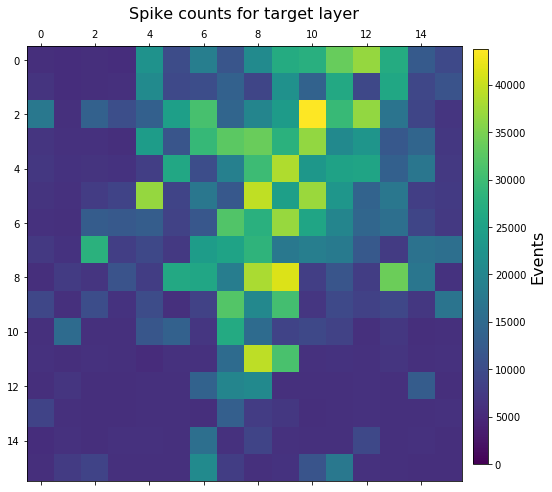

In [9]:
f, (ax1) = plt.subplots(1, 1 ,figsize=(8,8))
i = ax1.matshow(count_spikes.reshape(16,16), vmin=0)
ax1.grid(visible=False)
ax1.set_title("Spike counts for target layer", fontsize=16)
cbar_ax = f.add_axes([.91, 0.155, 0.025, 0.72])
cbar = f.colorbar(i, cax=cbar_ax)
cbar.set_label("Events", fontsize=16)

In [10]:
target_neuron_mean_spike_rate = count_spikes / float(simtime) * 1000.

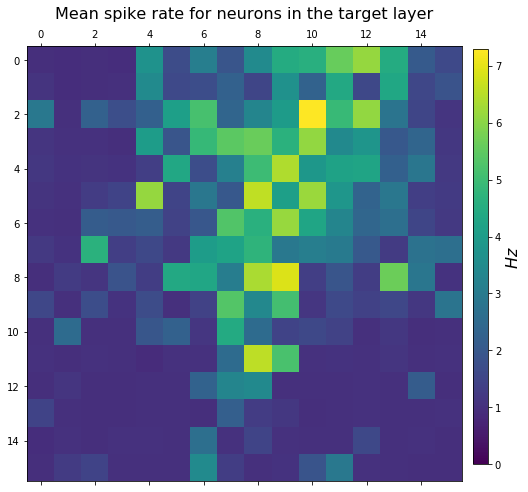

In [11]:
f, (ax1) = plt.subplots(1, 1 ,figsize=(8,8))
i = ax1.matshow(target_neuron_mean_spike_rate.reshape(16,16), vmin=0)
ax1.grid(visible=False)
ax1.set_title("Mean spike rate for neurons in the target layer", fontsize=16)
cbar_ax = f.add_axes([.91, 0.155, 0.025, 0.72])
cbar = f.colorbar(i, cax=cbar_ax)
cbar.set_label("$Hz$", fontsize=16)

In [12]:
total_target_neuron_mean_spike_rate = np.mean(target_neuron_mean_spike_rate)
print "Target neuron spike rate", total_target_neuron_mean_spike_rate, "Hz"

Target neuron spike rate 2.25145638021 Hz


In [13]:
ff_weights= data['final_pre_weights']

In [14]:
init_ff_weights = data['init_ff_connections']

In [15]:
simdata = np.array(data['sim_params']).ravel()[0]
print simdata

{'t_record': 30000, 'sigma_stim': 2, 'simtime': 6000000, 'sigma_form_forward': 2.5, 'p_form_forward': 0.16, 'f_base': 5, 's_max': 16, 'f_peak': 152.8, 'case': 3, 'p_elim_dep': 0.0245, 'p_form_lateral': 1, 'grid': array([16, 16]), 'g_max': 0.2, 't_stim': 20, 'sigma_form_lateral': 1, 'p_elim_pot': 0.024909268888678494, 'f_rew': 10000, 'cell_params': {'tau_refrac': 5.0, 'tau_m': 20.0, 'e_rev_E': 0.0, 'i_offset': 0.0, 'cm': 20.0, 'e_rev_I': -80.0, 'v_thresh': -50.0, 'tau_syn_E': 5.0, 'v_rest': -70.0, 'tau_syn_I': 5.0, 'v_reset': -70.0}}


In [16]:
ff_last = ff_weights.reshape(256,256)

In [17]:
number_ff_incoming_connections = np.count_nonzero(~np.isnan(ff_last), axis=0)
print number_ff_incoming_connections

[13 17 17 15 16 13 15 10 13 12 12 17 17 13 14 15 13 15 14 12 11  9 12  8 10
 12  8 15 10 16 13 17 12 13 14 18 13 15 14 11 11  8 16 15 18 10 10 14 11 15
  8 13 15  9 15 12 13 13 15 10 11 12 16 12 12 12 11 10 11 14  8 11 15 14 10
 10 14  3 11  9 13 11  7 10 17  9 10  9 16  9 13 13  9 13 12  9 14 13 11 12
 13  6 11 14 10 14 12 11  7  6 10 11  6  8 16  9  7  4  9 14 14 11 11 10 11
  6 16 15  9  7  9  9  9 16 15  8 17 15 11 12 19 13 10  9 17 10 13 12 12 11
  8 12  8 13 15 10 10  8 15 14  9 12 10 11 10 13  9 11  8 10  9 13  9  7 10
 15  9 11 12  7 11  8 11 16 15 16  4  9 11 13 12  8 11  8 12 11 11 10  9 10
 14 14  8 13  9 11 14 12 11  8  9 11 10 12 10 10 13 12 11 11  7  9 11  8 13
  9 11 12  8 11 13  8 12 12  8  8  9  8 10 12 13  9 15 12  8  7 12 11  9 12
 10 12  8  9  8 11]


In [86]:
final_mean_number_ff_synapses = np.mean(number_ff_incoming_connections)
print final_mean_number_ff_synapses

12.9375


In [87]:
initial_weight_mean = np.nanmean(init_ff_weights)
print "Initial weight mean", initial_weight_mean

Initial weight mean 0.2


In [88]:
final_weight_mean = np.nanmean(ff_last)
print "Final weight mean", final_weight_mean

Final weight mean 0.0914701747434


In [89]:
print "Weight as proportion of max for the initial number of synapses", final_weight_mean  / initial_weight_mean

Weight as proportion of max for the initial number of synapses 0.457350873717


# Sigma aff
We are looking for a location around which the afferent synapses have the lowest weighted variance. 

For this, we iterate over neuron locations (then we look at inter-neuron locations as well [1/10th of the unit distance]) and sum over all existing synapses

I can have a vector of 256 values [2560 values] so np.argmin works 

In [90]:
# Wiring
n = 16
N_layer = n ** 2
S = (n, n)
# S = (256, 1)
grid = np.asarray(S)
def distance(x0, x1, grid=np.asarray([16, 16]), type='euclidian'):
    x0 = np.asarray(x0)
    x1 = np.asarray(x1)
    delta = np.abs(x0 - x1)
    delta = np.where(delta > grid * .5, delta - grid, delta)

    if type == 'manhattan':
        return np.abs(delta).sum(axis=-1)
    return np.sqrt((delta ** 2).sum(axis=-1))

## Lowest weighted variance ($\sigma_{aff}^{2}$)


In [19]:
variances = np.ones((n,n)) * np.nan
for x in np.arange(n):
    top_sum = 0
    bottom_sum = 0
    for y in np.arange(n):
        active_synapses = np.argwhere(np.isfinite(ff_last[int(x * n + y), :])).ravel()
        bottom_sum = np.sum(ff_last[int(x * n + y), active_synapses])
        distances = np.zeros(active_synapses.size)
        for index in np.arange(active_synapses.size):
            distances[index] = distance((x, y), (active_synapses[index]//n, active_synapses[index]%n), grid)
        distances = distances ** 2
        top_sum = np.sum(np.multiply(distances, ff_last[int(x * n + y), active_synapses]))
        variances[int(x), int(y)] = float(top_sum) / bottom_sum
stds = np.sqrt(variances)
lowest_weighted_variance_location = (np.nanargmin(stds)//n, np.nanargmin(stds)%n)

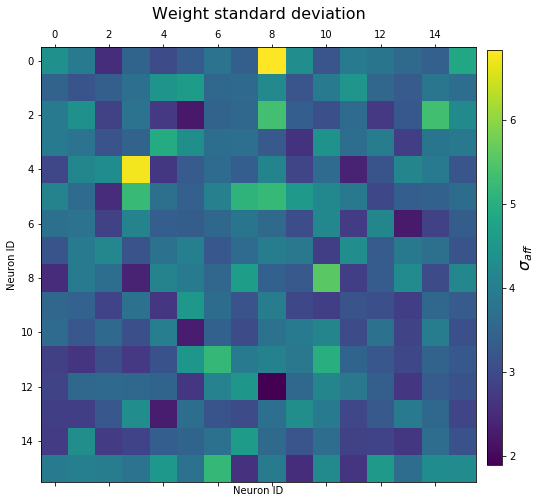

In [20]:
f, (ax1) = plt.subplots(1, 1 ,figsize=(8,8))
i = ax1.matshow(stds)
ax1.grid(visible=False)
ax1.set_title("Weight standard deviation", fontsize=16)
ax1.set_xlabel("Neuron ID")
ax1.set_ylabel("Neuron ID")
cbar_ax = f.add_axes([.91, 0.155, 0.025, 0.72])
cbar = f.colorbar(i, cax=cbar_ax)
cbar.set_label("$\sigma_{aff}$", fontsize=16)

In [21]:
np.nanargmin(stds)

200

In [22]:
stds[np.nanargmin(stds)//n, np.nanargmin(stds)%n]

1.89280977460295

In [23]:
np.mean(stds)

3.6007275749971601

## Absolute deviation (_AD_)

I have 1 preferred location for the entire network. Mean AD (I guess) means that I compute the distance from each neuron's ideal location to the 1 preferred location and take the mean of that. WCGW?

(The exact quote is ''Having calculated **the preferred location** for all the neurons in the target layer [...]''; it's not  ''the preferred location**s**'')

I'm still pretty sure there's supposed to be a preferred location for each target neuron...

In [143]:
distances = np.zeros(n**2)
for index in np.arange(distances.size):
    distances[index] = distance(lowest_weighted_variance_location, (index//n, index%n), grid)

In [145]:
distances

array([  5.38516481,   6.32455532,   7.28010989,   8.24621125,
         7.28010989,   6.32455532,   5.38516481,   4.47213595,
         3.60555128,   2.82842712,   2.23606798,   2.        ,
         2.23606798,   2.82842712,   3.60555128,   4.47213595,
         5.09901951,   6.08276253,   7.07106781,   8.06225775,
         7.07106781,   6.08276253,   5.09901951,   4.12310563,
         3.16227766,   2.23606798,   1.41421356,   1.        ,
         1.41421356,   2.23606798,   3.16227766,   4.12310563,
         5.        ,   6.        ,   7.        ,   8.        ,
         7.        ,   6.        ,   5.        ,   4.        ,
         3.        ,   2.        ,   1.        ,   0.        ,
         1.        ,   2.        ,   3.        ,   4.        ,
         5.09901951,   6.08276253,   7.07106781,   8.06225775,
         7.07106781,   6.08276253,   5.09901951,   4.12310563,
         3.16227766,   2.23606798,   1.41421356,   1.        ,
         1.41421356,   2.23606798,   3.16227766,   4.12

In [146]:
mean_AD = np.mean(distances)

In [147]:
print mean_AD

6.13903095224


# Alternative $\sigma_{aff}^{2}$

##$\sigma_{aff}^{2} = argmin_{\bar{x}} \frac{\Sigma_{i}w_{i}|\bar{p}_{xi}|^2}{\Sigma_{i}w_{i}}$

In [187]:
variances = np.ones((N_layer,N_layer)) * np.nan
preferred_locations = np.ones((n,n)) * np.nan
active_synapses_indices = np.where(np.isfinite(ff_last))
distances = np.ones((N_layer,N_layer)) * np.nan
bottom_sum = np.sum(ff_last[active_synapses_indices])
distances = np.ones((N_layer,N_layer)) * np.nan
for potential_preferred_location in np.arange(N_layer):
    for afferent_location in np.ndindex(grid[0], grid[1]):
        distances[potential_preferred_location, afferent_location[0]*n + afferent_location[1] ] = \
                distance((potential_preferred_location//n, potential_preferred_location%n), afferent_location, grid)**2

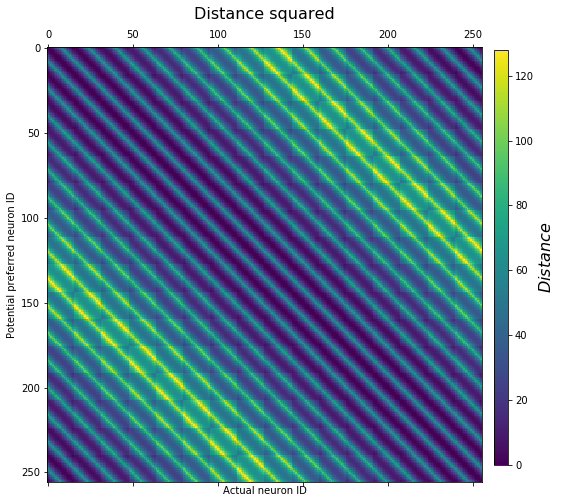

In [189]:
f, (ax1) = plt.subplots(1, 1 ,figsize=(8,8))
i = ax1.matshow(distances)
ax1.grid(visible=False)
ax1.set_title("Distance squared", fontsize=16)
ax1.set_xlabel("Actual neuron ID")
ax1.set_ylabel("Potential preferred neuron ID")
cbar_ax = f.add_axes([.91, 0.155, 0.025, 0.72])
cbar = f.colorbar(i, cax=cbar_ax)
cbar.set_label("$Distance$", fontsize=16)

In [192]:
weighted_distance = np.multiply(distances, ff_last)

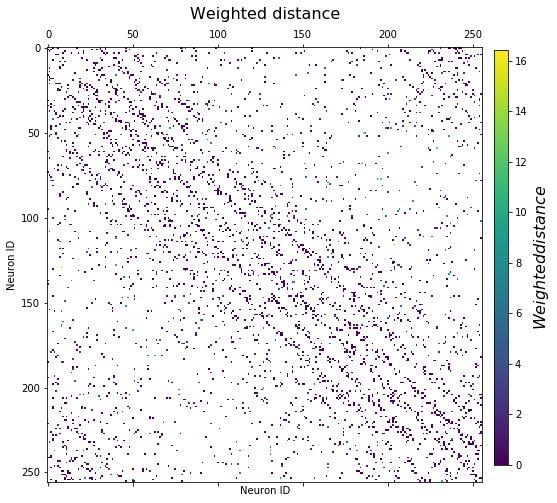

In [193]:
f, (ax1) = plt.subplots(1, 1 ,figsize=(8,8))
i = ax1.matshow(weighted_distance)
ax1.grid(visible=False)
ax1.set_title("Weighted distance", fontsize=16)
ax1.set_xlabel("Neuron ID")
ax1.set_ylabel("Neuron ID")
cbar_ax = f.add_axes([.91, 0.155, 0.025, 0.72])
cbar = f.colorbar(i, cax=cbar_ax)
cbar.set_label("$Weighted distance$", fontsize=16)

In [202]:
variance = np.nansum(weighted_distance, axis=1) / bottom_sum
variance = variance.reshape(16,16)

In [203]:
stds = np.sqrt(variance)
lowest_weighted_variance_location = (np.nanargmin(stds)//n, np.nanargmin(stds)%n)

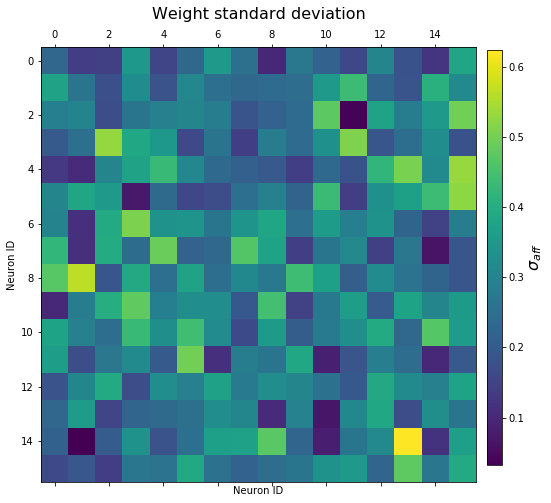

In [205]:
f, (ax1) = plt.subplots(1, 1 ,figsize=(8,8))
i = ax1.matshow(stds)
ax1.grid(visible=False)
ax1.set_title("Weight standard deviation", fontsize=16)
ax1.set_xlabel("Neuron ID")
ax1.set_ylabel("Neuron ID")
cbar_ax = f.add_axes([.91, 0.155, 0.025, 0.72])
cbar = f.colorbar(i, cax=cbar_ax)
cbar.set_label("$\sigma_{aff}$", fontsize=16)

In [206]:
print "lowest_weighted_variance_location", lowest_weighted_variance_location

lowest_weighted_variance_location (14, 1)


In [207]:
print "mean stds", np.mean(stds)
print "min stds", stds[lowest_weighted_variance_location]

mean stds 0.283402800782
min stds 0.0329833983166


# Checking $\sigma_{aff}$ and AD for initial connectivity

In [224]:
variances = np.ones((n,n)) * np.nan
for x in np.arange(n):
    top_sum = 0
    bottom_sum = 0
    for y in np.arange(n):
        active_synapses = np.argwhere(np.isfinite(init_ff_weights[int(x * n + y), :])).ravel()
        bottom_sum = np.sum(init_ff_weights[int(x * n + y), active_synapses])
        distances = np.zeros(active_synapses.size)
        for index in np.arange(active_synapses.size):
            distances[index] = distance((x, y), (active_synapses[index]//n, active_synapses[index]%n), grid)
        distances = distances ** 2
        top_sum = np.sum(np.multiply(distances, init_ff_weights[int(x * n + y), active_synapses]))
        variances[int(x), int(y)] = float(top_sum) / bottom_sum
stds = np.sqrt(variances)
lowest_weighted_variance_location = (np.nanargmin(stds)//n, np.nanargmin(stds)%n)

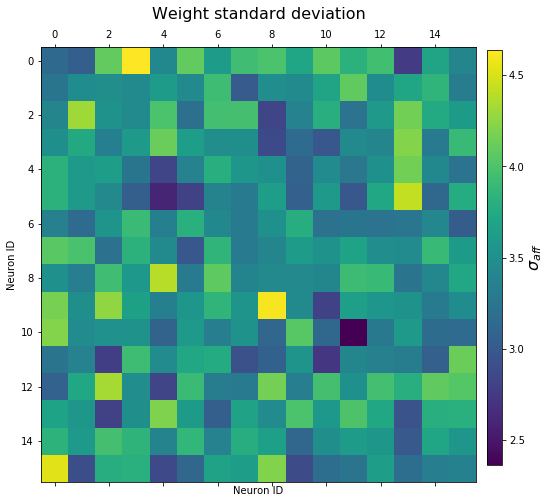

In [225]:
f, (ax1) = plt.subplots(1, 1 ,figsize=(8,8))
i = ax1.matshow(stds)
ax1.grid(visible=False)
ax1.set_title("Weight standard deviation", fontsize=16)
ax1.set_xlabel("Neuron ID")
ax1.set_ylabel("Neuron ID")
cbar_ax = f.add_axes([.91, 0.155, 0.025, 0.72])
cbar = f.colorbar(i, cax=cbar_ax)
cbar.set_label("$\sigma_{aff}$", fontsize=16)

In [226]:
np.nanargmin(stds)

171

In [227]:
print "location(",np.nanargmin(stds)//n, ",", np.nanargmin(stds)%n,")"

location( 10 , 11 )


In [228]:
stds[np.nanargmin(stds)//n, np.nanargmin(stds)%n]

2.3664319132398464

In [229]:
np.mean(stds)

3.5384075099352912

In [230]:
distances = np.zeros(n**2)
for index in np.arange(distances.size):
    distances[index] = distance(lowest_weighted_variance_location, (index//n, index%n), grid)

In [231]:
np.mean(distances)

6.1390309522432851

# Version 2

In [24]:
variances = np.ones((N_layer,N_layer)) * np.nan
preferred_locations = np.ones((n,n)) * np.nan
active_synapses_indices = np.where(np.isfinite(init_ff_weights))
distances = np.ones((N_layer,N_layer)) * np.nan
bottom_sum = np.sum(init_ff_weights[active_synapses_indices])
distances = np.ones((N_layer,N_layer)) * np.nan
for potential_preferred_location in np.arange(N_layer):
    for afferent_location in np.ndindex(grid[0], grid[1]):
        distances[potential_preferred_location, afferent_location[0]*n + afferent_location[1] ] = \
                distance((potential_preferred_location//n, potential_preferred_location%n), afferent_location, grid)**2

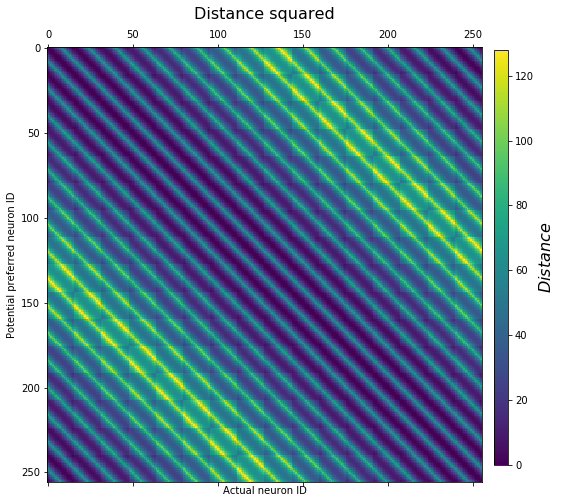

In [25]:
f, (ax1) = plt.subplots(1, 1 ,figsize=(8,8))
i = ax1.matshow(distances)
ax1.grid(visible=False)
ax1.set_title("Distance squared", fontsize=16)
ax1.set_xlabel("Actual neuron ID")
ax1.set_ylabel("Potential preferred neuron ID")
cbar_ax = f.add_axes([.91, 0.155, 0.025, 0.72])
cbar = f.colorbar(i, cax=cbar_ax)
cbar.set_label("$Distance$", fontsize=16)

In [26]:
weighted_distance = np.multiply(distances, init_ff_weights)

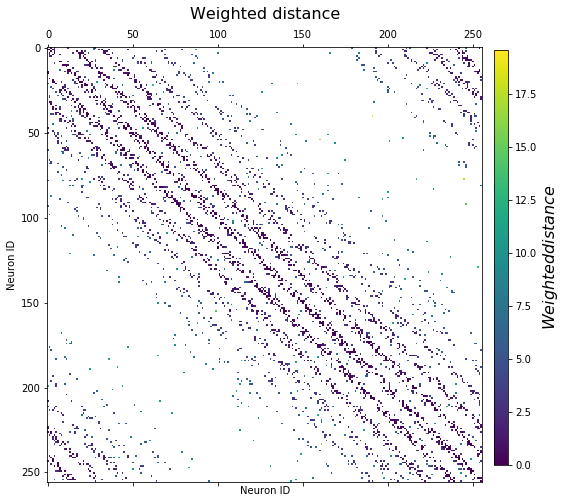

In [27]:
f, (ax1) = plt.subplots(1, 1 ,figsize=(8,8))
i = ax1.matshow(weighted_distance)
ax1.grid(visible=False)
ax1.set_title("Weighted distance", fontsize=16)
ax1.set_xlabel("Neuron ID")
ax1.set_ylabel("Neuron ID")
cbar_ax = f.add_axes([.91, 0.155, 0.025, 0.72])
cbar = f.colorbar(i, cax=cbar_ax)
cbar.set_label("$Weighted distance$", fontsize=16)

In [28]:
variance = np.nanmin(weighted_distance, axis=1) / bottom_sum
variance = variance.reshape(16,16)

In [29]:
stds = np.sqrt(variance)
lowest_weighted_variance_location = (np.nanargmin(stds)//n, np.nanargmin(stds)%n)

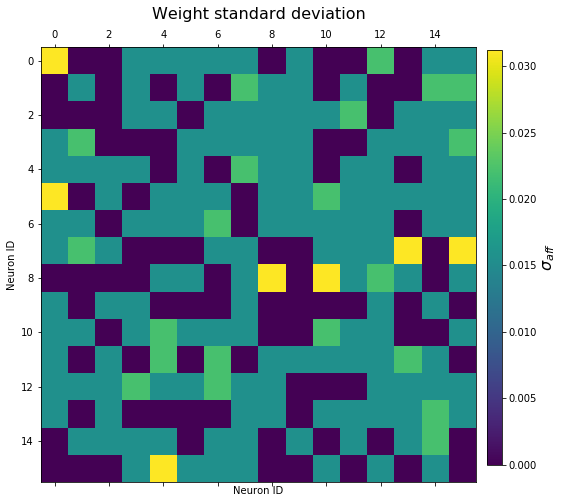

In [30]:
f, (ax1) = plt.subplots(1, 1 ,figsize=(8,8))
i = ax1.matshow(stds)
ax1.grid(visible=False)
ax1.set_title("Weight standard deviation", fontsize=16)
ax1.set_xlabel("Neuron ID")
ax1.set_ylabel("Neuron ID")
cbar_ax = f.add_axes([.91, 0.155, 0.025, 0.72])
cbar = f.colorbar(i, cax=cbar_ax)
cbar.set_label("$\sigma_{aff}$", fontsize=16)

In [31]:
print "lowest_weighted_variance_location", lowest_weighted_variance_location

lowest_weighted_variance_location (0, 1)


In [32]:
print "mean stds", np.mean(stds)
print "min stds", stds[lowest_weighted_variance_location]

mean stds 0.011151030567
min stds 0.0


# Restart

For each target cell, we're trying to establish where incoming connections are centred around and how big is the spread.

The preferred location for a target cell is that which minimises the weighted variance of synapses.

In [91]:
# Datastructure setup

variances = np.ones((N_layer,N_layer)) * np.nan
preferred_locations = np.ones((n,n)) * np.nan
active_synapses_indices = np.where(np.isfinite(init_ff_weights))
sum_of_weights = np.sum(init_ff_weights[active_synapses_indices])
distances = np.ones((N_layer,N_layer)) * np.nan

In [92]:
# Ignore the argmin, first just compute weighted variances for all possible source locations
for target_location in xrange(N_layer):#np.ndindex(16,16):
    for source_location in xrange(N_layer):#np.ndindex(16,16):
        # Distance must be computed between source_Location and the location of all presynaptic_neurons |pix|
        possible_sources = np.argwhere(active_synapses_indices[1]==target_location).ravel()
        distances = np.nan
        top_sum = 0
        
        # TODO something here needs to only focus on the current target_location
        for p_s in possible_sources:
            other_source = active_synapses_indices[0][p_s]
            distances = distance((source_location//n, source_location%n), (other_source//n, other_source%n), grid)**2
            top_sum += init_ff_weights[other_source, target_location] * distances

        variances[target_location, source_location] = top_sum / sum_of_weights

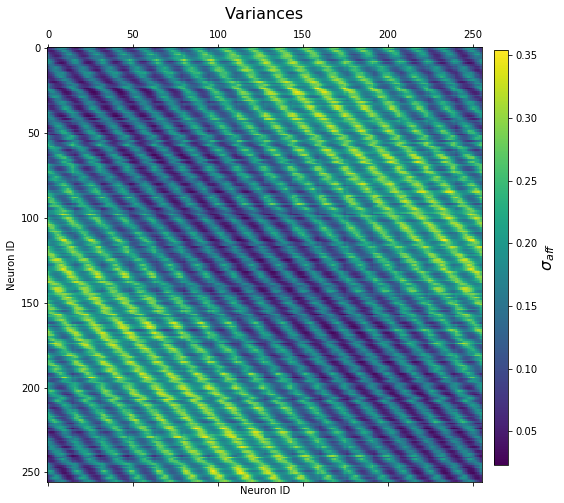

In [93]:
f, (ax1) = plt.subplots(1, 1 ,figsize=(8,8))
i = ax1.matshow(variances)
ax1.grid(visible=False)
ax1.set_title("Variances", fontsize=16)
ax1.set_xlabel("Neuron ID")
ax1.set_ylabel("Neuron ID")
cbar_ax = f.add_axes([.91, 0.155, 0.025, 0.72])
cbar = f.colorbar(i, cax=cbar_ax)
cbar.set_label("$\sigma_{aff}$", fontsize=16)

In [94]:
min_variances = np.nanmin(variances, axis=1).reshape(16,16)

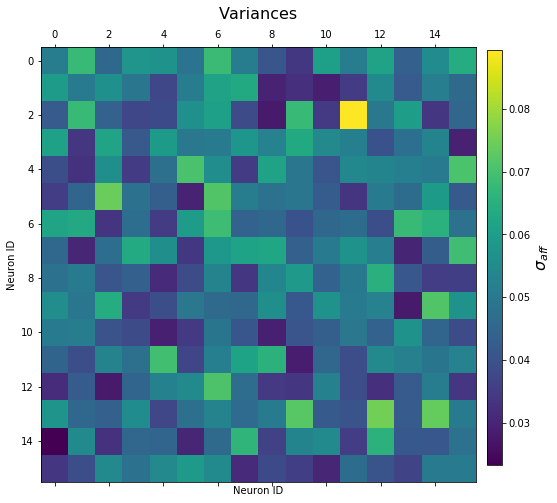

In [95]:
f, (ax1) = plt.subplots(1, 1 ,figsize=(8,8))
i = ax1.matshow(min_variances)
ax1.grid(visible=False)
ax1.set_title("Variances", fontsize=16)
ax1.set_xlabel("Neuron ID")
ax1.set_ylabel("Neuron ID")
cbar_ax = f.add_axes([.91, 0.155, 0.025, 0.72])
cbar = f.colorbar(i, cax=cbar_ax)
cbar.set_label("$\sigma_{aff}$", fontsize=16)

In [96]:
stds = np.sqrt(min_variances)

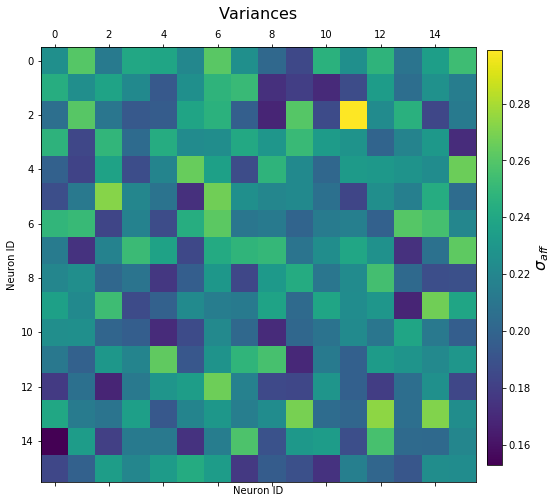

In [97]:
f, (ax1) = plt.subplots(1, 1 ,figsize=(8,8))
i = ax1.matshow(stds)
ax1.grid(visible=False)
ax1.set_title("Variances", fontsize=16)
ax1.set_xlabel("Neuron ID")
ax1.set_ylabel("Neuron ID")
cbar_ax = f.add_axes([.91, 0.155, 0.025, 0.72])
cbar = f.colorbar(i, cax=cbar_ax)
cbar.set_label("$\sigma_{aff}$", fontsize=16)

In [98]:
np.mean(stds)

0.21821573577632336

In [99]:
preferred_indices = np.argmin(variances, axis=1)
AD = np.ones(N_layer) * np.nan
for index in range(AD.size):
    AD[index] = distance((index//n, index%n),(preferred_indices[index]//n, preferred_indices[index]%n), grid)

In [100]:
AD

array([ 1.        ,  1.        ,  1.        ,  0.        ,  0.        ,
        0.        ,  1.41421356,  1.        ,  1.        ,  1.        ,
        0.        ,  1.41421356,  0.        ,  1.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  1.        ,  1.        ,
        1.        ,  0.        ,  1.41421356,  1.41421356,  1.        ,
        1.        ,  1.        ,  1.        ,  1.        ,  0.        ,
        1.        ,  0.        ,  1.        ,  1.        ,  0.        ,
        1.41421356,  1.        ,  0.        ,  1.        ,  0.        ,
        0.        ,  1.        ,  1.41421356,  1.        ,  0.        ,
        0.        ,  0.        ,  1.        ,  0.        ,  1.        ,
        0.        ,  1.        ,  1.        ,  0.        ,  1.        ,
        2.23606798,  2.23606798,  1.41421356,  0.        ,  1.        ,
        1.        ,  0.        ,  0.        ,  0.        ,  1.        ,
        0.        ,  1.41421356,  0.        ,  0.        ,  1.  

In [101]:
np.mean(AD)

0.73554535534893173

In [102]:
def sigma_and_ad(connectivity_matrix, unitary_weights=False, N_layer=256, n=16, resolution=1.):
    # Datastructure setup
    connectivity_matrix = np.copy(connectivity_matrix)
    variances = np.ones((N_layer, int(N_layer*resolution))) * np.nan
    preferred_locations = np.ones((n, n)) * np.nan
    active_synapses_indices = np.where(np.isfinite(connectivity_matrix))
    if unitary_weights:
        connectivity_matrix[active_synapses_indices] = 1.
    # Ignore the argmin, first just compute weighted variances for all possible source locations
    for target_location in xrange(N_layer):  # np.ndindex(16,16):
        for source_location in xrange(int(N_layer*resolution)):  # np.ndindex(16,16):
            # Distance must be computed between source_Location and the location of all presynaptic_neurons |pix|
            possible_sources = np.argwhere(active_synapses_indices[1] == target_location).ravel()
            top_sum = 0
            sum_of_weights = 0
            for p_s in possible_sources:
                other_source = active_synapses_indices[0][p_s]
                distances = distance(((source_location/resolution) // n, (source_location/resolution) % n), (other_source // n, other_source % n),
                                     grid) ** 2
                top_sum += connectivity_matrix[other_source, target_location] * distances
                sum_of_weights += connectivity_matrix[other_source, target_location]

            variances[target_location, source_location] = top_sum / sum_of_weights
    min_variances = np.nanmin(variances, axis=1).reshape(16, 16)
#     print min_variances.shape
    stds = np.sqrt(min_variances)
    preferred_indices = np.argmin(variances, axis=1)
    AD = np.ones(int(N_layer)) * np.nan
    for index in range(AD.size):
        AD[index] = distance(((index) // n, (index) % n), ((preferred_indices[index]/resolution) // n, (preferred_indices[index]/resolution) % n),
                             grid)

    # return mean std, stds, mean AD, ADs
    return np.mean(stds), stds, np.mean(AD), AD, min_variances

In [103]:
mean_std2, stds2, mean_AD2, AD2, variance2 = sigma_and_ad(ff_last)

In [104]:
mean_std2

4.183679249170118

In [105]:
mean_AD2

2.3850806048747302

In [106]:
preferred_indices.shape

(256L,)

In [107]:
variances.shape

(256L, 256L)

In [108]:
np.mean(variance2)

18.079916477795834

In [109]:
init_mean_std, init_stds, init_mean_AD, init_AD, init_variances = sigma_and_ad(init_ff_weights, )

In [110]:
init_mean_std

3.4914517724211738

In [111]:
init_mean_AD

0.73554535534893173

In [112]:
np.mean(init_variances)

12.3623046875

In [113]:
init_mean_std, init_stds, init_mean_AD, init_AD, init_variances = sigma_and_ad(init_ff_weights, unitary_weights=True, resolution=10.)

In [114]:
init_mean_std

3.4796813922911141

In [115]:
init_mean_AD

0.72868563711794709

In [116]:
np.mean(init_variances)

12.281171875

In [117]:
# use defaults
grid = np.asarray([16, 16])
s_max = 16
sigma_form_forward = 2.5
sigma_form_lateral = 1
p_form_lateral = 1
p_form_forward = 0.16
p_elim_dep = 0.0245
p_elim_pot = 1.36 * np.e ** -4
f_rew = 10 ** 4  # Hz
g_max = 0.2

from collections import Iterable
def formation_rule(potential_pre, post, sigma, p_form):
    d = distance(potential_pre, post)
    r = np.random.rand()
    p = p_form * (np.e ** (-(d ** 2 / (2 * (sigma ** 2)))))
    if r < p:
        return True
    return False


def generate_initial_connectivity(s, layer_size, sigma, p, weight):
    preexisting = []
    for _ in range(layer_size):
        preexisting.append([])

    if not isinstance(s, Iterable):
        print "not iterable"
        s = np.ones(layer_size) * s
        
    current_s = np.zeros(layer_size)
        
    connectivity_matrix = np.ones((layer_size, layer_size)) * np.nan
    for postsynaptic_neuron_index in range(layer_size):
        post = (postsynaptic_neuron_index // n, postsynaptic_neuron_index % n)
        while current_s[postsynaptic_neuron_index] < s[postsynaptic_neuron_index]:
            potential_pre_index = np.random.randint(0, N_layer)
            pre = (potential_pre_index // n, potential_pre_index % n)
            if potential_pre_index not in preexisting[postsynaptic_neuron_index]:
                if formation_rule(pre, post, sigma, p):
                    current_s[postsynaptic_neuron_index] += 1
                    preexisting[postsynaptic_neuron_index].append(
                        potential_pre_index)
                    connectivity_matrix[potential_pre_index, postsynaptic_neuron_index] = weight
    return connectivity_matrix

In [118]:
generated_ff_conn = generate_initial_connectivity(
            number_ff_incoming_connections, grid[0] * grid[1],
            sigma_form_forward, p_form_forward, g_max)

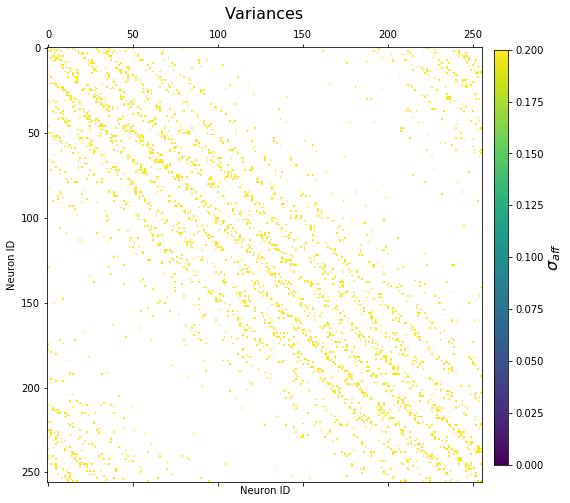

In [119]:
f, (ax1) = plt.subplots(1, 1 ,figsize=(8,8))
i = ax1.matshow(generated_ff_conn, vmin=0)
ax1.grid(visible=False)
ax1.set_title("Variances", fontsize=16)
ax1.set_xlabel("Neuron ID")
ax1.set_ylabel("Neuron ID")
cbar_ax = f.add_axes([.91, 0.155, 0.025, 0.72])
cbar = f.colorbar(i, cax=cbar_ax)
cbar.set_label("$\sigma_{aff}$", fontsize=16)

In [120]:
np.count_nonzero(np.isfinite(generated_ff_conn), axis=0)

array([14, 11, 17, 12, 16, 21, 16, 13, 17, 15, 14, 18, 15, 17, 12, 15, 13,
       15, 15, 15, 12, 16, 11, 17, 15, 16, 11, 16, 13, 15,  9, 15, 13, 10,
       15, 17, 17, 12, 11, 15, 12, 13,  9, 14, 11, 15, 12, 16, 14,  9, 13,
       14, 13, 13, 13, 17, 16, 13, 10, 13, 13, 14, 14,  8, 14, 13, 17, 16,
       12, 11, 12, 13, 12, 13, 11, 13, 10, 16, 13, 12, 12, 10, 17, 14, 10,
       13, 14, 12, 13, 14, 10, 15, 11, 10, 13, 12, 14, 11, 12, 14,  9, 12,
       14, 12, 16,  7, 13,  9, 12, 12, 11, 15, 12, 14, 14, 12, 11, 17, 14,
       12, 13, 11, 13,  9, 11, 12, 12, 11, 12, 12, 10, 14, 15, 12, 18, 13,
       13, 13, 13, 13, 13, 10, 10, 16, 11, 15, 16, 15,  7, 15,  9, 11,  8,
       13, 13, 12, 13, 16, 11, 13, 11, 11, 13, 13, 13, 15, 10, 12, 13, 13,
       10, 15, 16, 13, 13, 13, 14,  9, 11, 14, 12, 13, 11, 13, 14, 14, 11,
       12, 11, 10, 13, 17,  8, 14, 12, 11, 14, 13, 17, 16, 11, 15, 11, 17,
       12, 11, 15, 16, 13, 15, 13, 15, 16, 11, 14, 10, 13, 10, 14, 16,  8,
       11,  8, 13, 13, 14

In [121]:
number_ff_incoming_connections

array([14, 11, 17, 12, 16, 21, 16, 13, 17, 15, 14, 18, 15, 17, 12, 15, 13,
       15, 15, 15, 12, 16, 11, 17, 15, 16, 11, 16, 13, 15,  9, 15, 13, 10,
       15, 17, 17, 12, 11, 15, 12, 13,  9, 14, 11, 15, 12, 16, 14,  9, 13,
       14, 13, 13, 13, 17, 16, 13, 10, 13, 13, 14, 14,  8, 14, 13, 17, 16,
       12, 11, 12, 13, 12, 13, 11, 13, 10, 16, 13, 12, 12, 10, 17, 14, 10,
       13, 14, 12, 13, 14, 10, 15, 11, 10, 13, 12, 14, 11, 12, 14,  9, 12,
       14, 12, 16,  7, 13,  9, 12, 12, 11, 15, 12, 14, 14, 12, 11, 17, 14,
       12, 13, 11, 13,  9, 11, 12, 12, 11, 12, 12, 10, 14, 15, 12, 18, 13,
       13, 13, 13, 13, 13, 10, 10, 16, 11, 15, 16, 15,  7, 15,  9, 11,  8,
       13, 13, 12, 13, 16, 11, 13, 11, 11, 13, 13, 13, 15, 10, 12, 13, 13,
       10, 15, 16, 13, 13, 13, 14,  9, 11, 14, 12, 13, 11, 13, 14, 14, 11,
       12, 11, 10, 13, 17,  8, 14, 12, 11, 14, 13, 17, 16, 11, 15, 11, 17,
       12, 11, 15, 16, 13, 15, 13, 15, 16, 11, 14, 10, 13, 10, 14, 16,  8,
       11,  8, 13, 13, 14

In [122]:
np.count_nonzero(np.isfinite(init_ff_weights), axis=0)

array([16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16,
       16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16,
       16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16,
       16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16,
       16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16,
       16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16,
       16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16,
       16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16,
       16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16,
       16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16,
       16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16,
       16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16,
       16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16,
       16, 16, 16, 16, 16

In [123]:
def weight_shuffle(connectivity_matrix):
    positions_to_be_shuffled = np.argwhere(np.isfinite(connectivity_matrix))
    permutation = np.random.permutation(positions_to_be_shuffled)
    permuted_connectivity_matrix = np.ones(connectivity_matrix.shape) * np.nan
    for index in range(positions_to_be_shuffled.shape[0]):
        permuted_connectivity_matrix[positions_to_be_shuffled[index][0], positions_to_be_shuffled[index][1]] = connectivity_matrix[permutation[index][0], permutation[index][1]]
    return permuted_connectivity_matrix

In [124]:
weights_shuf = weight_shuffle(ff_last)

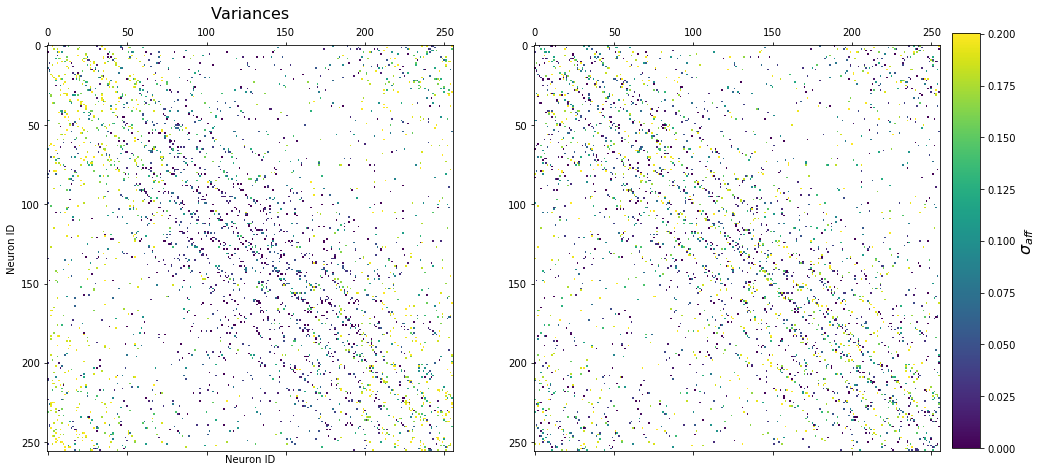

In [125]:

f, (ax1, ax2) = plt.subplots(1, 2 ,figsize=(16,8))
i = ax1.matshow(ff_last, vmin=0)
ax2.matshow(weights_shuf, vmin=0)
ax1.grid(visible=False)
ax1.set_title("Variances", fontsize=16)
ax1.set_xlabel("Neuron ID")
ax1.set_ylabel("Neuron ID")
cbar_ax = f.add_axes([.91, 0.155, 0.025, 0.72])
cbar = f.colorbar(i, cax=cbar_ax)
cbar.set_label("$\sigma_{aff}$", fontsize=16)

In [126]:
ff_diff =ff_last - weights_shuf

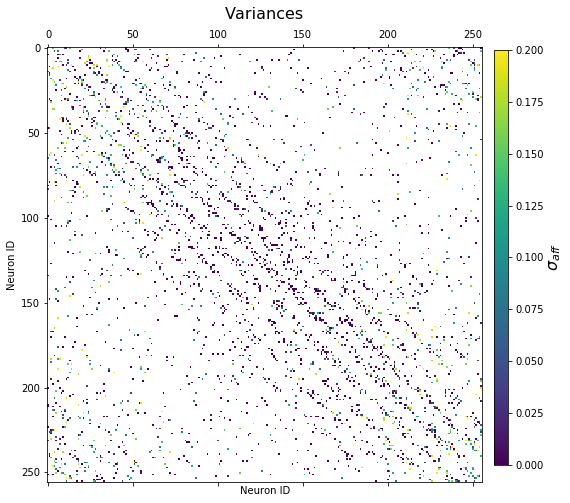

In [127]:
f, (ax1) = plt.subplots(1, 1 ,figsize=(8,8))
i = ax1.matshow(ff_diff, vmin=0)
ax1.grid(visible=False)
ax1.set_title("Variances", fontsize=16)
ax1.set_xlabel("Neuron ID")
ax1.set_ylabel("Neuron ID")
cbar_ax = f.add_axes([.91, 0.155, 0.025, 0.72])
cbar = f.colorbar(i, cax=cbar_ax)
cbar.set_label("$\sigma_{aff}$", fontsize=16)

In [128]:
np.sum(np.count_nonzero(np.isfinite(ff_last), axis=0))

3312

In [129]:
np.sum(np.count_nonzero(np.isfinite(ff_diff), axis=0))

3312

In [130]:
np.sum(np.count_nonzero(np.isfinite(weights_shuf), axis=0))

3312

In [131]:
data.close()